# Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

Обучающая и тестовая выборка состоят из отрывков из мультсериала Симпсоны. Каждая картинка представлена в формате jpg c необходимой меткой - названием персонажа изображенного на ней. Тест был поделен на приватную и публичную часть в соотношении 95/5

В тренировочном датасете примерно по 1000 картинок на каждый класс, но они отличаются размером.

Важный момент: метки классов представлены в виде названий папок, в которых лежат картинки. Это сделано для того, чтобы вы могли без проблем использовать библиотечные загрузчики данных, а не писали свои, тратя на это весь свой последний(единственный) день, который вы отвели на задание :)



### Описание файлов
- train.csv - the training set
- testset.csv - the test set
- sampleSubmission.csv - пример решения, если у вас нет времени на задание

### Поля в данных
- image_id - id картинки
- Expected - имя персонажа

### Цель:
Получить качественный классификатор изображений на 42 класса, ключевая метрика - F1

### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
import pandas as pd
import seaborn as sns

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CUDA is available!  Training on GPU ...


Зададим константы, которыми будем пользоваться

In [15]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
N_CORES = 2
BATCH_SIZE = 64 #128
RESCALE_SIZE = 224
EPOCHS = 20

Зададим процессор, который нам доступен

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# для колаба
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [5]:
# для кагла
!ls /kaggle/input/simpsons/simpsons_dataset
# для колаба
#!ls /content/gdrive/'MyDrive'/'Colab Notebooks'/DLS/datasets/simpsons_dataset.zip

test  train


In [6]:
# для колаба
#!unzip -q /content/gdrive/'MyDrive'/'Colab Notebooks'/DLS/datasets/simpsons_dataset.zip -x "__MACOSX/*"

In [8]:
# для колаба
#!ls simpsons_dataset/train
# для кагла проверка существующих классов
!ls /kaggle/input/simpsons/simpsons_dataset/train

abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


In [9]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Aug 11 13:14:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [10]:
import pickle
import numpy as np
import math
import random
from skimage import io
import os
from sklearn.model_selection import train_test_split

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import datasets, models, transforms

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
from multiprocessing.pool import ThreadPool
import torch.optim as optim

from typing import Dict

import torch


from collections import Counter

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [11]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Этот код выполняет следующие действия:

1. Определяет две переменные `TRAIN_DIR` и `TEST_DIR`, которые содержат пути к директориям с данными обучения и тестирования соответственно. `Path` - это объект из библиотеки `pathlib`, который представляет путь к файлу или директории в операционной системе.

2. `train_val_files` создает список файлов обучающего набора данных, ищет все файлы с расширением `.jpg` внутри директории `TRAIN_DIR` и ее поддиректориях (рекурсивно). Затем список сортируется в алфавитном порядке.

3. `test_files` аналогично создает список файлов тестового набора данных, на этот раз в директории `TEST_DIR`.

В результате, после выполнения этого кода, `train_val_files` будет содержать список путей к изображениям обучающего набора, а `test_files` - список путей к изображениям тестового набора. Эти списки могут быть использованы для дальнейшей загрузки данных, обучения моделей и выполнения других операций.

In [14]:
# для колаба
#TRAIN_DIR = Path('/content/simpsons_dataset/train')
#TEST_DIR = Path('/content/simpsons_dataset/test')

# для кагла
TRAIN_DIR = Path('/kaggle/input/simpsons/simpsons_dataset/train')
TEST_DIR = Path('/kaggle/input/simpsons/simpsons_dataset/test')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [16]:
train_val_files[0:5]

[PosixPath('/kaggle/input/simpsons/simpsons_dataset/train/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('/kaggle/input/simpsons/simpsons_dataset/train/abraham_grampa_simpson/pic_0000_0.jpg'),
 PosixPath('/kaggle/input/simpsons/simpsons_dataset/train/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('/kaggle/input/simpsons/simpsons_dataset/train/abraham_grampa_simpson/pic_0001_0.jpg'),
 PosixPath('/kaggle/input/simpsons/simpsons_dataset/train/abraham_grampa_simpson/pic_0002.jpg')]

Создаем список лейблов

In [17]:
train_val_labels = [path.parent.name for path in train_val_files]

Этот код определяет функцию `load_image`, которая выполняет следующие действия:

1. Принимает входной аргумент `file`, который представляет путь к файлу изображения.

2. Открывает изображение с помощью `Image.open(file)`. `Image` здесь представляет класс из библиотеки Pillow (PIL), используемой для работы с изображениями.

3. Метод `.load()` вызывается для того, чтобы фактически загрузить содержимое изображения. Это может быть полезно, если вам нужно, чтобы вся информация об изображении была доступна в оперативной памяти, например, перед обработкой или аугментацией.

4. Возвращает объект изображения.

Таким образом, эта функция загружает изображение из файла, гарантируя, что оно полностью загружено и доступно для дальнейшей обработки или использования.

In [18]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

Посчитаем кол-ва изображений в каждом классе, создаем агрегированную таблицу

In [19]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

In [20]:
data = get_count(train_val_labels)

Этот код определяет функцию `show_data`, которая использует библиотеки `matplotlib` и `seaborn` для визуализации данных в виде столбчатой диаграммы:

1. Принимает входной аргумент `data`, который представляет собой набор данных (вероятно, DataFrame или подобную структуру), содержащий информацию для отображения на диаграмме.

2. `min_level` и `max_level` - это опциональные параметры, которые контролируют, будут ли на диаграмме отображаться горизонтальные линии, обозначающие минимальный и максимальный уровни.

3. Создает новую фигуру (рисунок) с помощью `plt.figure(figsize=(15, 9))`, задавая размеры фигуры в дюймах.

4. С помощью `sns.barplot` создает столбчатую диаграмму, где по оси X будут размещены значения `data.index` (вероятно, это категориальные метки), а по оси Y - значения из столбца `'count'` данных `data`.

5. `orient='v'` указывает, что диаграмма должна быть вертикальной.

6. `.set_xticklabels(data.index, rotation=90)` устанавливает подписи по оси X, используя метки `data.index`, и поворачивает их на 90 градусов для лучшей читаемости.

7. Если `max_level` истинно, добавляется горизонтальная линия (`plt.axhline(y=1500)`), чтобы отметить максимальный уровень на диаграмме. 

8. Если `min_level` истинно, добавляется красная горизонтальная линия (`plt.axhline(y=100, color='red')`), чтобы отметить минимальный уровень на диаграмме.

9. `plt.show()` отображает созданную диаграмму.

Эта функция помогает визуализировать данные в виде столбчатой диаграммы с дополнительными горизонтальными линиями для обозначения определенных уровней.

In [21]:
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=1500)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()

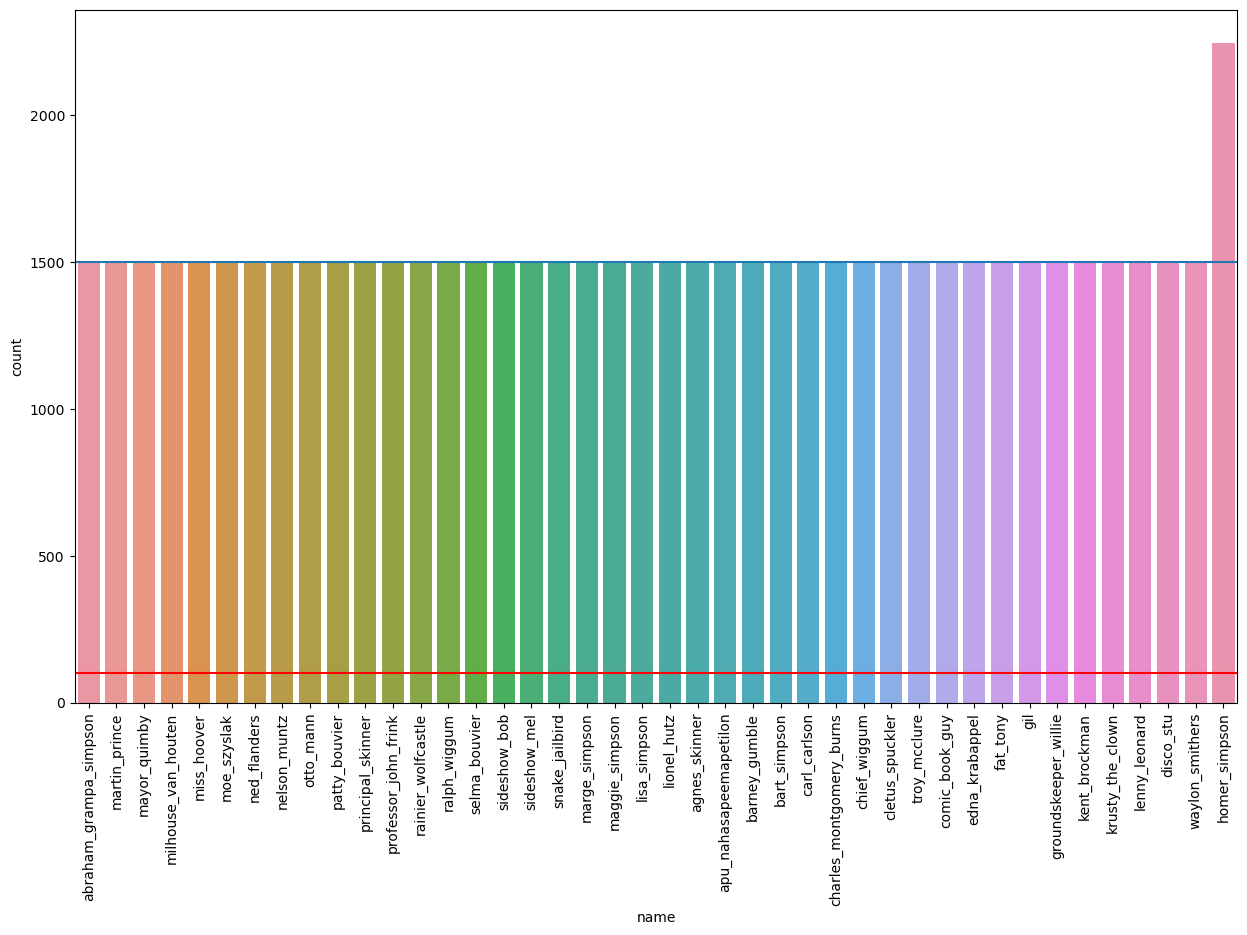

In [22]:
show_data(data)

Примечание: диаграмма может быть не верна, потому что возможно ячейка запущена после аугментации

As we can see, the data is highly unbalanced.

We would also recommend to manually add images for classes with less then 100 images, because extending such little number of images only by augmentation may not give desired result.

Let's say we would like to have at least 1500 images per class.

In [31]:
data['to_add'] = data['count'].apply(lambda x: 1500 - x if x < 1500 else 0)

The one_iteration column will show us, how much new images we should make from one original image.

Этот код выполняет следующие действия:

1. `data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)`: Создает новый столбец в DataFrame `data` с именем 'one_iteration'. Этот столбец будет содержать значения, которые представляют количество итераций, которые необходимо выполнить, чтобы добавить определенное количество элементов (`to_add`) в каждую категорию.

2. `data.apply(...)`: Применяет функцию ко всем строкам DataFrame. В данном случае, применяется функция, заданная через `lambda`.

3. `lambda x: math.ceil(x['to_add'] / x['count'])`: Это анонимная функция, которая принимает каждую строку `x` как аргумент. Она вычисляет значение для нового столбца 'one_iteration'. В данном случае, она берет значение 'to_add' (количество элементов для добавления) из строки `x` и делит его на значение 'count' (количество элементов в категории) из той же строки. После этого, с помощью `math.ceil` округляется результат до ближайшего большего целого числа.

4. `axis=1`: Указывает, что функция должна применяться по строкам (по горизонтали).

5. `data`: Завершает операцию и возвращает измененный DataFrame `data`, в котором теперь есть новый столбец 'one_iteration', содержащий количество итераций для добавления элементов в каждую категорию.

Таким образом, этот код создает новый столбец 'one_iteration', который вычисляет, сколько итераций необходимо для добавления определенного количества элементов в каждую категорию в DataFrame `data`.

In [32]:
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)
data

,count,to_add,one_iteration
name,,,
lionel_hutz,3,1497,499
disco_stu,8,1492,187
troy_mcclure,8,1492,187
miss_hoover,17,1483,88
fat_tony,27,1473,55
gil,27,1473,55
otto_mann,32,1468,46
sideshow_mel,40,1460,37
agnes_skinner,42,1458,35


We decided to randomly apply one of the following 3 transforms:

* RandomCrop (Resize and CenterCrop are used to turn the image into a squared one)
* RandomRotation
* RandomHorizontalFlip
More types of transformation can be found at PyTorch [Illustration of transforms](https://pytorch.org/vision/master/auto_examples/plot_transforms.html)

In [23]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

В первом пункте все три аугментации применяются последовательно к изображению. Давайте рассмотрим их действия более подробно:

1. `transforms.Resize(size=300, max_size=301)`: В этой трансформации изображение изменяется так, чтобы его длинная сторона (большая из сторон) стала равной 300 пикселям. Однако, если изображение изначально было более большим, чем 301x301 пиксель, то оно будет уменьшено до 301x301 пикселя, чтобы сохранить минимальный размер, который потребуется для последующего вырезания (Crop). Если изображение уже меньше 301x301 пикселя, то оно останется без изменений.

2. `transforms.CenterCrop(size=300)`: Эта трансформация берет изображение и вырезает центральную часть размером 300x300 пикселей. Это действие создает более компактное изображение, центрированное вокруг центра оригинала.

3. `transforms.RandomCrop(250)`: Здесь случайным образом вырезается кусок изображения размером 250x250 пикселей из случайного места. Важно, что этот этап случайного вырезания выполняется после предыдущих аугментаций. Это создает дополнительное разнообразие путем случайного выделения части изображения.

В результате, когда вы примените эту последовательность трансформаций к изображению, сначала оно будет приведено к определенному размеру (не менее 301x301), затем центральная часть будет вырезана размером 300x300, и, наконец, случайный кусок размером 250x250 будет вырезан из этой центральной части. Таким образом, изображение пройдет через несколько этапов преобразования, создавая разнообразные варианты для обучения модели.

We can check how augmented data will look like.

Давайте разберем этот код подробнее:

1. `img_label`: Это переменная, содержащая название класса, полученное из пути к файлу изображения.

2. `.split('_')`: Этот метод разделяет строку `img_label` на части, используя символ подчеркивания (`_`) в качестве разделителя. Например, если `img_label` равно `"class_name_subclass"`, то после разделения получится список `["class", "name", "subclass"]`.

3. `map(lambda x: x.capitalize(), ... )`: Здесь `map` применяет функцию `lambda` к каждому элементу в списке, преобразуя каждую часть строки в формат с заглавной буквой (капитализацию). Функция `lambda x: x.capitalize()` принимает строку `x` и возвращает эту строку с первой буквой в верхнем регистре.

4. `" ".join(...)`: Этот метод объединяет элементы списка, полученного после применения `map`, с помощью пробела между элементами. В результате получается одна строка, где каждое слово начинается с заглавной буквы и разделено пробелом.

Пример:
Предположим, `img_label = "class_name_subclass"`. Шаги будут следующими:

- `img_label.split('_')` даст список `["class", "name", "subclass"]`.
- `map(lambda x: x.capitalize(), ...)` применит к каждому элементу заглавную букву: `["Class", "Name", "Subclass"]`.
- `" ".join(...)"` объединит элементы списка в одну строку: `"Class Name Subclass"`.

Таким образом, выражение `" ".join(map(lambda x: x.capitalize(), img_label.split('_')))` преобразует название класса из формата `"class_name_subclass"` в читабельный вид `"Class Name Subclass"`, где каждое слово начинается с заглавной буквы и разделено пробелом.

`augmenters.items()` используется для получения пар ключ-значение из словаря `augmenters`. В контексте этого кода, `augmenters` представляет собой словарь, в котором ключами являются имена различных аугментаций, а значениями являются функции (аугментеры) для преобразования изображений.

Функция `items()` словаря возвращает итерируемый объект, состоящий из кортежей, где каждый кортеж содержит пару ключ-значение из словаря. В данном случае, каждый кортеж будет иметь вид `(ключ, значение)`, где `ключ` представляет имя аугментации, а `значение` представляет соответствующую функцию аугментации.

Используя `for augmenter_name, augmenter in augmenters.items()`, вы можете перебрать каждую пару ключ-значение в словаре `augmenters`, где `augmenter_name` будет содержать имя аугментации, а `augmenter` будет содержать соответствующую функцию аугментации.

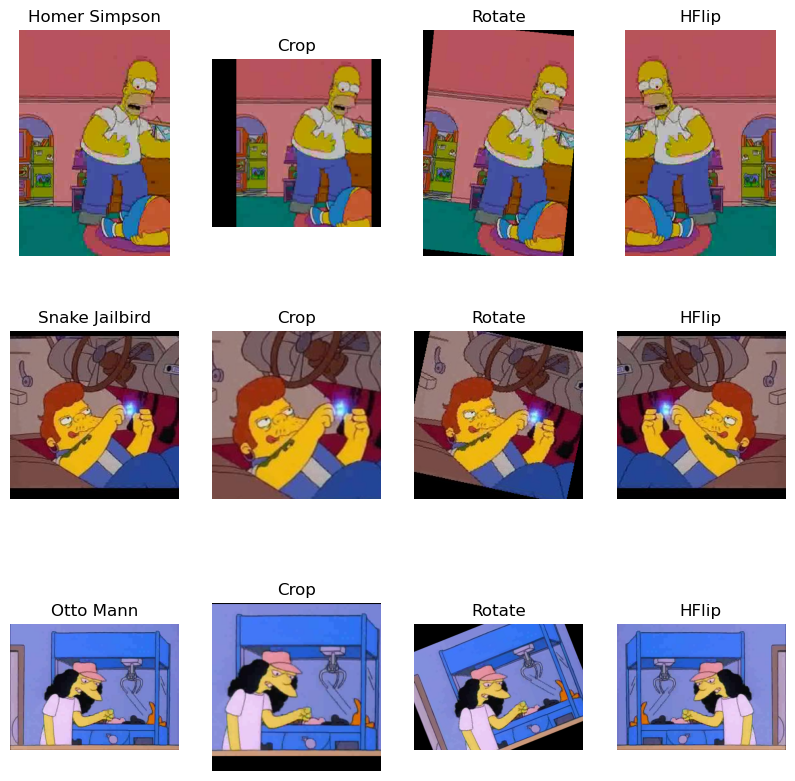

In [24]:
n_examples = 3

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = load_image(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name

    img_label = " ".join(map(lambda x: x.capitalize(),\
                img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')

    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

Let's run a cycle for all images in the train folder.

In [25]:
train_val_files[0]

PosixPath('/kaggle/input/simpsons/simpsons_dataset/train/abraham_grampa_simpson/pic_0000.jpg')

In [26]:
train_val_files[0].parents[0]

PosixPath('/kaggle/input/simpsons/simpsons_dataset/train/abraham_grampa_simpson')

Этот код реализует аугментацию изображений для определенных классов на основе заданных правил аугментации. Давайте разберем шаги этого кода:

1. `for image_path in tqdm(train_val_files):` - Проходит через список файлов `train_val_files`, представляющий пути к изображениям в обучающем наборе данных.

2. `path = image_path.parents[0]` - Извлекает путь к директории, содержащей изображение.

3. `character = image_path.parent.name` - Извлекает имя класса (персонажа) из пути к директории, в которой находится изображение.

4. `img = load_image(image_path)` - Загружает изображение, используя функцию `load_image`.

5. `if data.loc[character]['to_add'] <= 0:` - Проверяет, нужно ли добавлять аугментированные изображения для данного класса. Если количество аугментированных изображений, которое нужно добавить, меньше или равно нулю, пропускает текущую итерацию.

6. `if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:` - Проверяет, какое значение (`one_iteration` или `to_add`) следует использовать для создания аугментированных изображений. Если количество изображений для создания на одной итерации больше оставшегося количества аугментированных изображений, использует `to_add` вместо `one_iteration`.

7. `iter_size = data.loc[character]['to_add']` или `iter_size = data.loc[character]['one_iteration']` - Задает размер итерации (сколько аугментированных изображений создать на этой итерации).

8. `data.loc[character]['to_add'] -= iter_size` - Уменьшает оставшееся количество аугментированных изображений для данного класса на размер текущей итерации.

9. Внутри цикла `for i in range(iter_size):` происходит следующее:
   - Выбирается случайный аугментер из словаря `augmenters` с помощью `random.choice(list(augmenters.values()))`.
   - Применяется аугментация к загруженному изображению: `aug_img = augmenter(img)`.
   - Аугментированное изображение сохраняется в ту же директорию с измененным именем файла, чтобы отразить, что это аугментированное изображение.

В итоге этот код применяет определенные аугментации к изображениям определенных классов и сохраняет аугментированные изображения в той же директории.

In [41]:
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue

    # if number of images to create for one iteration is greater than the rest of images to create,
    # we should use 'to_add' instead of 'one_iteration'
    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character]['to_add'] -= iter_size

    for i in range(iter_size):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 20933/20933 [01:52<00:00, 186.34it/s]


In [42]:
!zip -r "journey-springfield-augmented.zip" . > /dev/null

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported

zip warning: Operation not supported


In [27]:
len(train_val_files)

63746

Этот код создает архив с именем "simpsons_dataset.zip", который содержит все файлы и папки из директории "simpsons_dataset". Архивирование происходит рекурсивно, то есть включаются все поддиректории и файлы, находящиеся внутри "simpsons_dataset". 

Команда `!zip -r simpsons_dataset.zip simpsons_dataset`:
- `zip` - это команда для создания архивов.
- `-r` - флаг "рекурсивно", который указывает на необходимость архивирования содержимого папки и всех её подпапок и файлов.
- `simpsons_dataset.zip` - это имя создаваемого архива.
- `simpsons_dataset` - это имя директории, которая будет архивирована.

После выполнения этой команды создается архив "simpsons_dataset.zip", содержащий все файлы и папки из директории "simpsons_dataset".

In [44]:
!zip -r simpsons_dataset.zip simpsons_dataset


Выходные данные были обрезаны до нескольких последних строк (5000).

  adding: simpsons_dataset/train/chief_wiggum/pic_0392.jpg (deflated 8%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0327.jpg (deflated 8%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0256.jpg (deflated 6%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0339_0.jpg (deflated 1%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0201.jpg (deflated 3%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0482_0.jpg (deflated 4%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0869.jpg (deflated 5%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0819.jpg (deflated 7%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0905.jpg (deflated 6%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0161.jpg (deflated 2%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0011_0.jpg (deflated 8%)

  adding: simpsons_dataset/train/chief_wiggum/pic_0587.jpg (deflated 12%)

  adding: simpsons_dataset/train/chi

Начинаем работу с аугментированными данными

In [28]:
# для колаба
#TRAIN_DIR = Path('/content/simpsons_dataset/train')
#TEST_DIR = Path('/content/simpsons_dataset/test')

# для кагл
TRAIN_DIR = Path('/kaggle/input/simpsons/simpsons_dataset/train')
TEST_DIR = Path('/kaggle/input/simpsons/simpsons_dataset/test')

aug_files  = sorted(list(TRAIN_DIR.rglob('*.jpg')))
aug_labels = [path.parent.name for path in aug_files]
aug_data = get_count(aug_labels)

In [29]:
len(aug_files)

63746

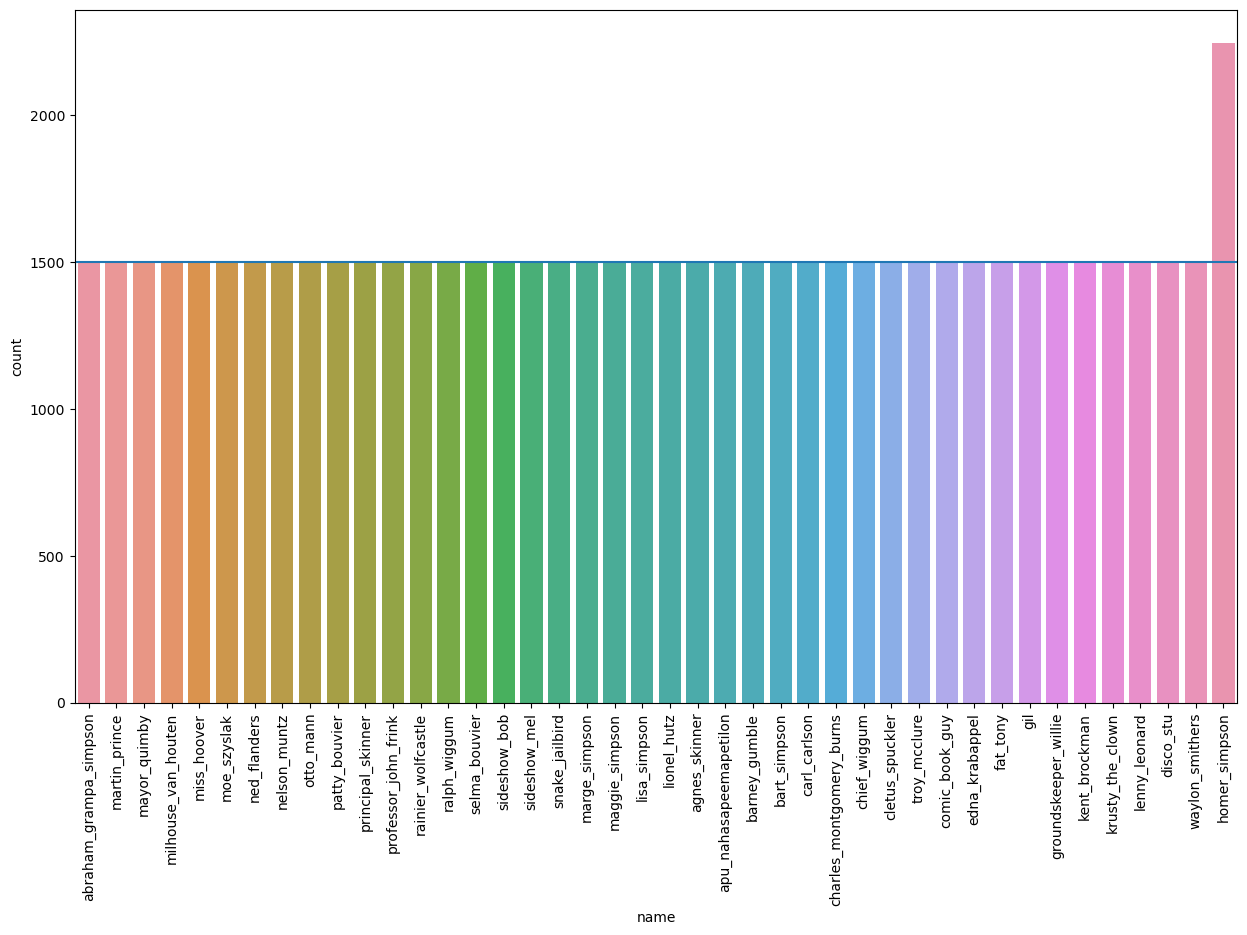

In [30]:
show_data(aug_data, min_level=False)

Делим датасет на тренировочную и валидационную

In [31]:
train_files, val_files = train_test_split(aug_files, test_size=0.25, \
                                          stratify=aug_labels)

In [32]:
len(train_files)

47809

Пока train_files, val_files у нас содержат только список путей к изображениям. Нужно сделать из них датасеты. Для этого создадим класс SimpsonsDataset

Код определяет пользовательский класс датасета для работы с изображениями в задаче классификации персонажей "Симпсонов". Разберем каждую часть класса по порядку:

1. `class SimpsonsDataset(Dataset):` - Определение класса наследующего от `torch.utils.data.Dataset`, что позволяет использовать этот класс внутри PyTorch для работы с данными.

2. `def __init__(self, files, mode):` - Метод-конструктор класса. Он принимает список файлов `files` и режим работы `mode` (один из элементов списка `DATA_MODES`, предполагается, что это либо `'train'`, `'val'` или `'test'`).

3. Внутри конструктора:
   - `self.files = sorted(files)` - Сохраняет список файлов для загрузки изображений и сортирует их.
   - `self.mode = mode` - Сохраняет режим работы датасета.
   - `self.len_ = len(self.files)` - Сохраняет количество файлов в датасете.

4. `def __len__(self):` - Метод, возвращающий длину (количество образцов) датасета.

5. `def load_sample(self, file):` - Метод, загружающий изображение из файла с помощью библиотеки `PIL` (Python Imaging Library).

6. `def __getitem__(self, index):` - Метод, возвращающий образец из датасета по заданному индексу.
   - `transform = transforms.Compose([...])` - Создает цепочку преобразований для изображения, включая преобразование в тензор и нормализацию.
   - `x = self.load_sample(self.files[index])` - Загружает изображение.
   - `x = self._prepare_sample(x)` - Применяет метод `_prepare_sample()` для изменения размера изображения.
   - `x = np.array(x / 255, dtype='float32')` - Преобразует изображение в массив NumPy и выполняет нормирование путем деления на 255.
   - `x = transform(x)` - Применяет определенные ранее преобразования.
   - Если режим датасета не `'test'`, то выполняется следующее:
     - `label = self.labels[index]` - Получает метку (имя папки, соответствующей классу персонажа) для данного изображения.
     - `label_id = self.label_encoder.transform([label])` - Преобразует метку в числовое значение, используя кодировщик меток.
     - `y = label_id.item()` - Преобразует числовое значение метки в скалярное значение Python.
     - Возвращает обработанное изображение и соответствующую метку класса.
   - Если режим датасета `'test'`, возвращает только обработанное изображение.

7. `def _prepare_sample(self, image):` - Внутренний метод для изменения размера изображения:
   - `image = image.resize((RESCALE_SIZE, RESCALE_SIZE))` - Изменяет размер изображения на заданный.
   - Возвращает измененное изображение в виде массива NumPy.

Общий результат - класс `SimpsonsDataset`, который позволяет загружать и обрабатывать изображения, подготавливая их для использования в моделях машинного обучения с помощью библиотеки PyTorch.

`with open('label_encoder.pkl', 'wb') as le_dump_file:

                  pickle.dump(self.label_encoder, le_dump_file)`
выполняет сохранение объекта `self.label_encoder` в файл с именем `'label_encoder.pkl'` с использованием модуля `pickle`. Здесь происходит сериализация (преобразование объекта Python в байтовую последовательность) объекта `self.label_encoder` и его запись в файл в двоичном режиме (`'wb'`).

Сериализация позволяет сохранить состояние объекта между сеансами выполнения программы. В данном случае, `self.label_encoder` - это объект кодировщика меток (LabelEncoder), который используется для преобразования строковых меток классов в числовые значения. Сохранение этого объекта позволит в будущем восстановить точно такой же объект кодировщика меток при загрузке модели для инференса (прогнозирования) на новых данных.

In [33]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)



In [34]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [35]:
val_dataset = SimpsonsDataset(val_files, mode='val')

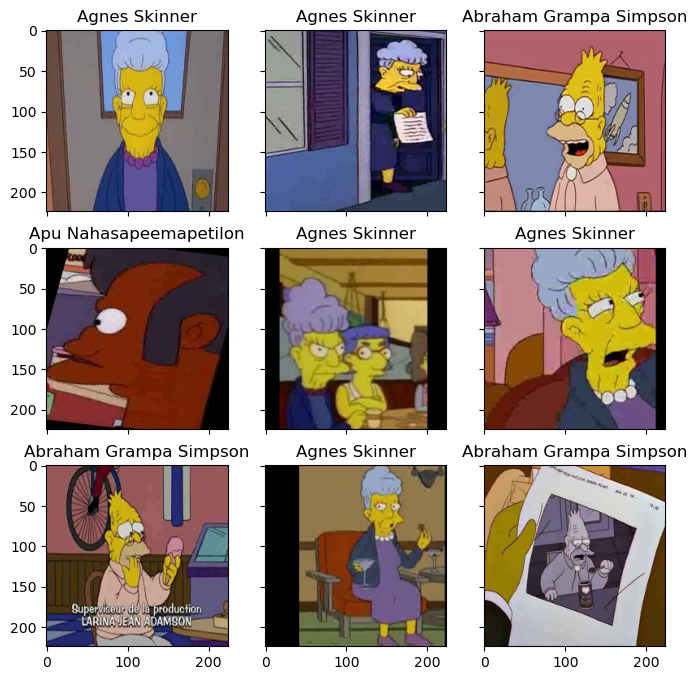

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [37]:
#!pip install timm


## Загрузка модели и обучение

Загружаем предобученную модель efficientnet_b2. Меняем классификатор, добавив 2 линейных слоя  с активациями и батчнормом

In [38]:
from torchvision import models
n_classes = len(np.unique(train_val_labels))

efficientnet_b2 = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1, progress=True)

for param in efficientnet_b2.parameters():
    param.requires_grad = True

efficientnet_b2.classifier = nn.Sequential(
    nn.Linear(1408, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, n_classes)
)
optimizer = torch.optim.Adam(efficientnet_b2.parameters(), lr=0.0003)

efficientnet_b2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 125MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Функция для обучения одной эпохи

In [39]:
def fit_epoch(model, train_loader, criterion, optimizer, sheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train(True) #добавлено для оптимизации

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)


    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    if sheduler is not None: #добавлено для оптимизации
        sheduler.step(train_loss) #добавлено для оптимизации
    return train_loss, train_acc

Функция для валидации на 1 эпохе

In [40]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Функция для тренировки на всех эпохах 

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.Adam(model.parameters())
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

Функция для предсказания 

In [42]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [43]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

Задаем оптимизатор и scheduler

In [44]:
optimizer = optim.AdamW(efficientnet_b2.parameters(), lr=0.001, weight_decay=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


**Обучение модели**

In [45]:
%%time
#history = train(train_dataset, val_dataset, model=efficientnet_b2, epochs=25, batch_size=64)
model, history = train(train_dataset, val_dataset, model=efficientnet_b2, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, optimizer=optimizer, sheduler=scheduler)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.18814946131243715


epoch:   5%|▌         | 1/20 [13:06<4:09:00, 786.36s/it]


Epoch 001 train_loss: 0.1881     val_loss 0.0837 train_acc 0.9584 val_acc 0.9775
loss 0.05520372914207031


epoch:  10%|█         | 2/20 [25:18<3:46:23, 754.62s/it]


Epoch 002 train_loss: 0.0552     val_loss 0.0658 train_acc 0.9853 val_acc 0.9831
loss 0.041218806957546233


epoch:  15%|█▌        | 3/20 [37:24<3:30:06, 741.58s/it]


Epoch 003 train_loss: 0.0412     val_loss 0.0514 train_acc 0.9891 val_acc 0.9887
loss 0.03761674024566501


epoch:  20%|██        | 4/20 [49:29<3:15:56, 734.76s/it]


Epoch 004 train_loss: 0.0376     val_loss 0.0581 train_acc 0.9896 val_acc 0.9844
loss 0.030935707070724027


epoch:  25%|██▌       | 5/20 [1:01:26<3:02:05, 728.37s/it]


Epoch 005 train_loss: 0.0309     val_loss 0.0478 train_acc 0.9912 val_acc 0.9895
loss 0.02711097647895857


epoch:  30%|███       | 6/20 [1:13:21<2:48:55, 723.99s/it]


Epoch 006 train_loss: 0.0271     val_loss 0.0610 train_acc 0.9924 val_acc 0.9848
loss 0.021921692850061653


epoch:  35%|███▌      | 7/20 [1:25:18<2:36:20, 721.59s/it]


Epoch 007 train_loss: 0.0219     val_loss 0.0750 train_acc 0.9940 val_acc 0.9828
loss 0.024181226916444122


epoch:  40%|████      | 8/20 [1:37:19<2:24:18, 721.57s/it]


Epoch 008 train_loss: 0.0242     val_loss 0.0615 train_acc 0.9929 val_acc 0.9871
loss 0.01777965052271402


epoch:  45%|████▌     | 9/20 [1:49:21<2:12:17, 721.57s/it]


Epoch 009 train_loss: 0.0178     val_loss 0.0472 train_acc 0.9950 val_acc 0.9880
loss 0.020205910371034155


epoch:  50%|█████     | 10/20 [2:01:26<2:00:26, 722.68s/it]


Epoch 010 train_loss: 0.0202     val_loss 0.0472 train_acc 0.9941 val_acc 0.9899
loss 0.017152970762478233


epoch:  55%|█████▌    | 11/20 [2:13:26<1:48:16, 721.87s/it]


Epoch 011 train_loss: 0.0172     val_loss 0.0511 train_acc 0.9950 val_acc 0.9895
loss 0.015349982302708818


epoch:  60%|██████    | 12/20 [2:25:31<1:36:22, 722.87s/it]


Epoch 012 train_loss: 0.0153     val_loss 0.0366 train_acc 0.9955 val_acc 0.9915
loss 0.016713796255285


epoch:  65%|██████▌   | 13/20 [2:37:33<1:24:17, 722.47s/it]


Epoch 013 train_loss: 0.0167     val_loss 0.0460 train_acc 0.9953 val_acc 0.9904
loss 0.016110942813531027


epoch:  70%|███████   | 14/20 [2:49:34<1:12:12, 722.13s/it]


Epoch 014 train_loss: 0.0161     val_loss 0.0395 train_acc 0.9956 val_acc 0.9925
loss 0.014094704930421371


epoch:  75%|███████▌  | 15/20 [3:01:31<1:00:02, 720.60s/it]


Epoch 015 train_loss: 0.0141     val_loss 0.0621 train_acc 0.9957 val_acc 0.9866
loss 0.009954046434123053


epoch:  80%|████████  | 16/20 [3:13:28<47:57, 719.46s/it]  


Epoch 016 train_loss: 0.0100     val_loss 0.0454 train_acc 0.9970 val_acc 0.9923
loss 0.01493025290245819


epoch:  85%|████████▌ | 17/20 [3:25:28<35:58, 719.57s/it]


Epoch 017 train_loss: 0.0149     val_loss 0.0455 train_acc 0.9960 val_acc 0.9909
loss 0.011070068780933652


epoch:  90%|█████████ | 18/20 [3:37:25<23:57, 718.70s/it]


Epoch 018 train_loss: 0.0111     val_loss 0.0500 train_acc 0.9968 val_acc 0.9909
loss 0.01290092837442154


epoch:  95%|█████████▌| 19/20 [3:49:29<12:00, 720.49s/it]


Epoch 019 train_loss: 0.0129     val_loss 0.0472 train_acc 0.9964 val_acc 0.9906
Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.
loss 0.011624902628840745


epoch: 100%|██████████| 20/20 [4:01:29<00:00, 724.46s/it]


Epoch 020 train_loss: 0.0116     val_loss 0.0420 train_acc 0.9969 val_acc 0.9922
Best val Acc: 0.992501
CPU times: user 2h 37min 3s, sys: 14min 48s, total: 2h 51min 51s
Wall time: 4h 1min 29s


In [46]:
loss, acc, val_loss, val_acc = zip(*history) 

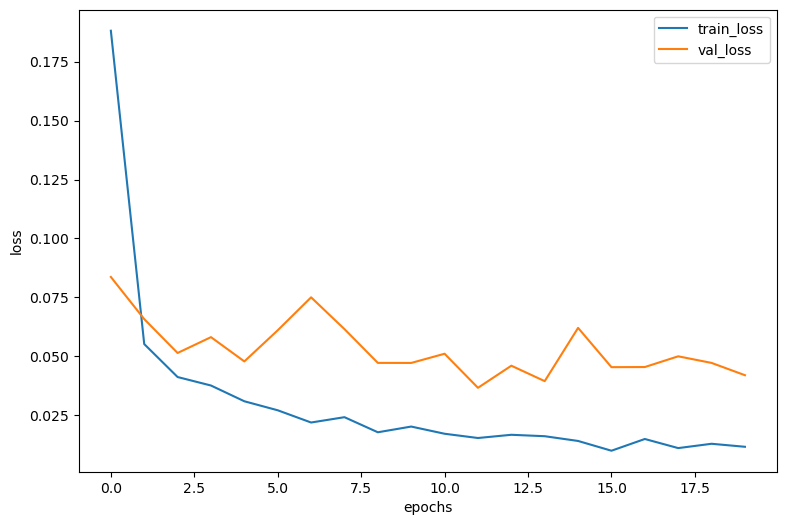

In [47]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

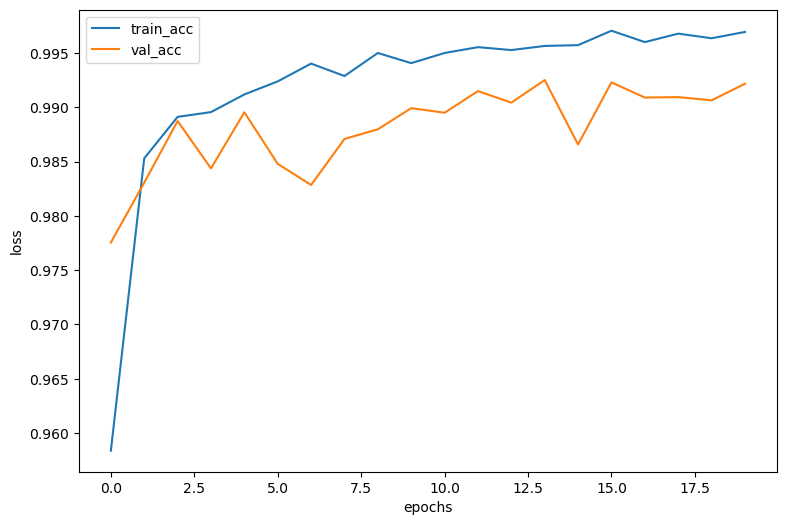

In [48]:
plt.figure(figsize=(9, 6))
plt.plot([item for item in acc], label="train_acc")
plt.plot([item.cpu() for item in val_acc], label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [50]:
def predict_one_sample(model, inputs, device=device):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [52]:
random_characters = int(np.random.uniform(0,len(val_dataset)))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(efficientnet_b2, ex_img.unsqueeze(0))

In [54]:
idxs = list(map(int, np.random.uniform(0,len(val_dataset), 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(efficientnet_b2, imgs)

In [55]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [56]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [57]:
list(y_pred)

[36, 6, 15, 13, 10, 17, 39, 35, 21, 16, 17, 10, 27, 11, 4, 13, 20, 30, 20, 1]

In [58]:
idxs

[14024,
 2333,
 6119,
 5065,
 4061,
 6779,
 15020,
 13437,
 8325,
 6362,
 6882,
 4026,
 10481,
 4210,
 1773,
 5114,
 7762,
 11607,
 7766,
 554]

In [59]:
actual_labels

[36, 6, 15, 13, 10, 17, 39, 35, 21, 16, 17, 10, 27, 11, 4, 13, 20, 30, 20, 1]

In [60]:
val_dataset[5100][1]

13

In [61]:
preds_class

['selma_bouvier',
 'charles_montgomery_burns',
 'homer_simpson',
 'gil',
 'disco_stu',
 'krusty_the_clown',
 'snake_jailbird',
 'ralph_wiggum',
 'maggie_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'disco_stu',
 'moe_szyslak',
 'edna_krabappel',
 'bart_simpson',
 'gil',
 'lisa_simpson',
 'otto_mann',
 'lisa_simpson',
 'agnes_skinner']

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [62]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average="micro")

1.0

Рандомно посмотрим какие классы с какой увернностью распозновала наша модель

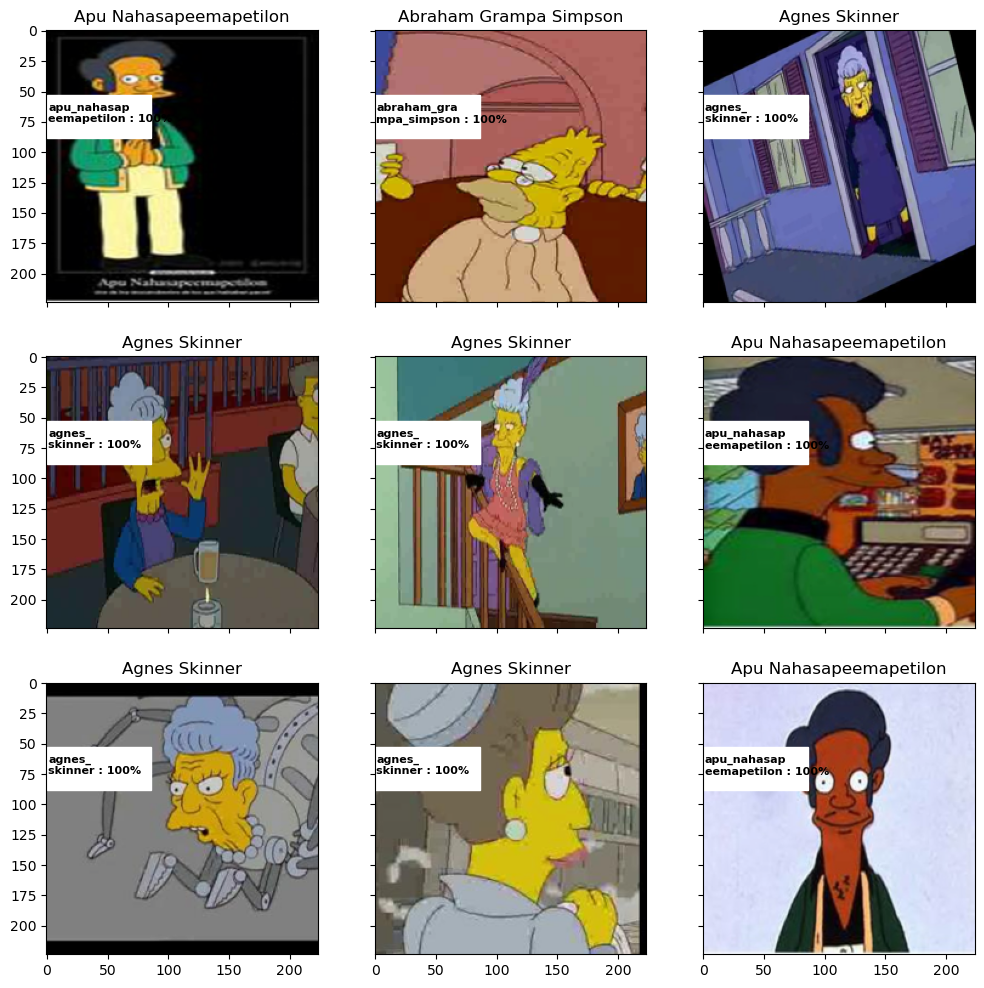

In [64]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(efficientnet_b2, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [65]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(efficientnet_b2, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [70]:
! ls

label_encoder.pkl


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/DLS/datasets/sample_submission.csv")
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [71]:
import pandas as pd
#my_submit = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/DLS/datasets/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [72]:
my_submit.shape

(991, 2)

In [74]:
my_submit.to_csv('efficientnet_b2_aug.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [75]:
torch.save(efficientnet_b2, 'efficientnet_b2_aug.pth')

**Вывод:**
- Предобработка данных:
    - Был сильный дисбаланс классов,поэтому сделали аугментацию данных, чтобы увеличить кол-во маленьких классов
- Была выбрана и обучена модель `EfficientNet_b2` для классифакация изображений персонажей Симпсонов на 42 класса:
    - Была взята предобученная на данных ImageNet модель. Заменили классификтор на пользовательский, который классифицирует на 42 класса
    - Получили accuracy на валидацинной выборке `0.99`
    - Целевой метрикой соревнования была метрика f1.  Получили на публичном тесте значение `f1 = 0.99256`